import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [1]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import pandas
import geopandas as gpd
from shapely.geometry import shape, Point

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be re

In [2]:
player_df = pd.read_csv("data/player_gdf.csv", index_col=0)
player_gdf = gpd.read_file("data/player_gdf.geojson")[['fullName', 'geometry']]

<IPython.core.display.Javascript object>

## Data Engineering

In [3]:
# just player coords
player_coords = player_df[['fullName', 'Lat', 'Lng']]

In [4]:
# flipping the lat and longitude 
flipped_geom = [Point(coord.y, coord.x) for coord in player_gdf['geometry']]
player_gdf['geometry'] = flipped_geom

# Clustergram

K=1 fitted in 0.720430850982666 seconds.
K=2 fitted in 1.1631710529327393 seconds.
K=3 fitted in 1.4697468280792236 seconds.
K=4 fitted in 1.882439136505127 seconds.
K=5 fitted in 2.2145307064056396 seconds.
K=6 fitted in 2.7497122287750244 seconds.
K=7 fitted in 2.9629979133605957 seconds.
K=8 fitted in 3.446730136871338 seconds.
K=9 fitted in 3.366076946258545 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

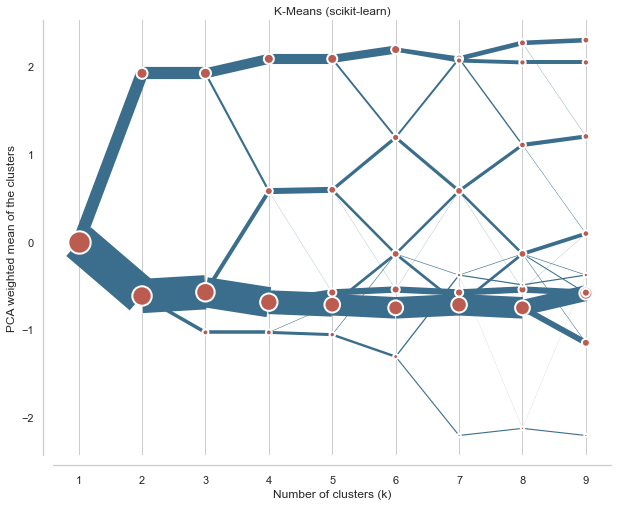

In [5]:
# from the clustergram project page 
data = scale(player_coords.drop(columns=['fullName']))

cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(data)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

## Analyzing the optimal number of clusters

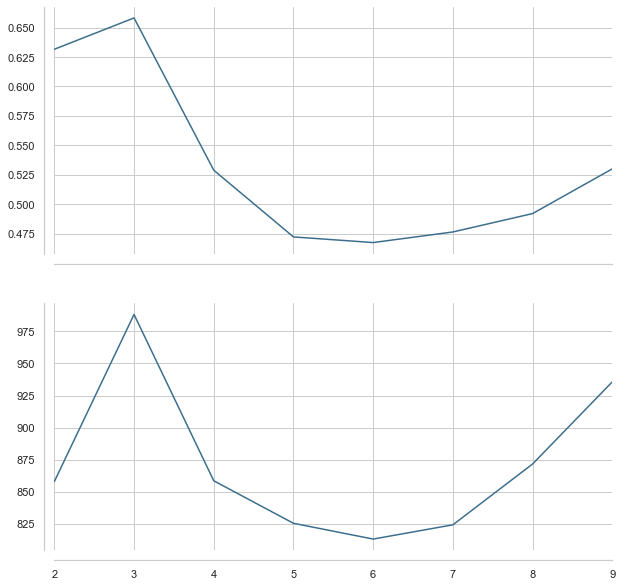

In [6]:
# also from the project page 
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
# score of 1 is best with the silhouette score
cgram.silhouette_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Silhouette score",
    color=ugg.COLORS[1],
    ax=axs[0],
)
# the higher the value, the better
cgram.calinski_harabasz_score().plot(
#     xlabel="Number of clusters (k)",
#     ylabel="Calinski-Harabasz score",
    color=ugg.COLORS[1],
    ax=axs[1],
)
sns.despine(offset=10)

**3 clusters looks optimal**. Therefore, when we use a clustering algorithm (e.g.: Kmeans), we know the number of clusters for it to create.

# Cluster the data - Kmeans

In [7]:
# adjusting the data to be an array
X = np.array(player_coords[['Lat', 'Lng']])

<IPython.core.display.Javascript object>

In [8]:
# applying Kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [9]:
# adding labels to player_gdf
player_gdf['player_cluster'] = kmeans.labels_

In [10]:
kmeans.cluster_centers_

array([[  43.24011627,  -77.3498787 ],
       [  48.92488235, -117.14823277],
       [  44.952668  ,  -94.8177072 ]])

# Plotting Data

<AxesSubplot:>

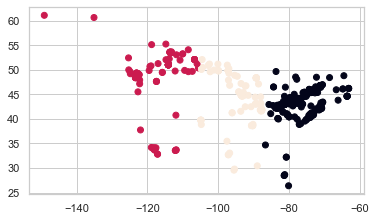

In [11]:
player_gdf.plot(column='player_cluster')

## Adding Centroids to the data

In [12]:
player_gdf.head(2)

,fullName,geometry,player_cluster
0,Nathan Bastian,POINT (-80.47280 43.41860),0
1,Tyce Thompson,POINT (-114.06670 51.05000),1


In [13]:
centroid_gdf = gpd.GeoDataFrame(data=[f"Cluster{x}" for x in range(0, 3)], columns = ['fullName'])

In [14]:
# making the centroids into points
centroid_gdf['geometry'] = [Point(coord[1], coord[0]) for coord in kmeans.cluster_centers_]
centroid_gdf['player_cluster'] = [x for x in range(4, 7)]

In [15]:
# cluster0's centroid is near Rochester, NY, USA
# cluster1's centroid is near the northern Washington/Idaho border, USA
# cluster2's centroid is west of Minneapolis, MN, USA
centroid_gdf

,fullName,geometry,player_cluster
0,Cluster0,POINT (-77.34988 43.24012),4
1,Cluster1,POINT (-117.14823 48.92488),5
2,Cluster2,POINT (-94.81771 44.95267),6


In [16]:
# merging the two
player_gdf_w_centroids = pd.concat([player_gdf, centroid_gdf])
# player_gdf.concat(centroid_gdf)

<IPython.core.display.Javascript object>

In [17]:
type(player_gdf_w_centroids)

geopandas.geodataframe.GeoDataFrame

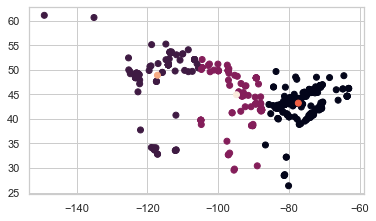

In [20]:
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
player_gdf_w_centroids.plot(column='player_cluster')
# plt.savefig("pictures/player_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

## How many players are in each cluster?

In [19]:
# clusters: 0 = east coast, 1 = west coast, 2 = central
# 2-3x more players in cluster 0 (east coast) than other clusters
player_gdf.player_cluster.value_counts()

0    338
2    125
1    119
Name: player_cluster, dtype: int64